In [1]:
%env AWS_NO_SIGN_REQUEST=YES

env: AWS_NO_SIGN_REQUEST=YES


# 读取影像
`raster-vision`基于`GDAL`对矢量、影像进行处理，所以`GDAL`支持的数据格式，理论上`raster-vision`也支持，并且`raster-vision`还扩展了对`S3`的支持。
1. [GDAL支持的遥感影像列表](https://gdal.org/en/stable/drivers/raster/index.html)
2. [GDAL支持的矢量格式列表](https://gdal.org/en/stable/drivers/vector/index.html)
   
`RasterioSource`是`raster-vision`的遥感影像IO的一个核心类，它提供了读取、写入、裁剪、重采样等操作。

1. 从S3加载

In [2]:
from rastervision.core.data import RasterioSource

img_uri = 's3://azavea-research-public-data/raster-vision/examples/spacenet/RGB-PanSharpen_AOI_2_Vegas_img205.tif'
raster_source = RasterioSource(img_uri, allow_streaming=True)
raster_source.shape

/opt/conda/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


(650, 650, 3)

2. 从本地加载

In [3]:
from rastervision.core.data import RasterioSource

file_uri = "data/RGB-PanSharpen_AOI_2_Vegas_img205.tif"
raster_source = RasterioSource(file_uri, allow_streaming=True)
raster_source.shape


(650, 650, 3)

# 影像处理
`raster-vision`提供了一系列的影像处理算子`Transformer`，同时`RasterioSource`还支持像`numpy`一样直接进行切片。
1. MinMaxTransforme
2. StatsTransformer
3. CastTransformer
4. NanTransformer
在构造`RasterioSource`的时候，就可以传递一个`Transformer`，`RasterioSource`在我们获取数据的时候会自动应用`Transformer`。  

接下来，我们先看看`RasterioSource`的切片操作。

1. 影像裁剪,裁剪一个 400x400 的影像

In [4]:
chip = raster_source[:400, :400]
chip.shape

(400, 400, 3)

2. 归一化。为了渲染图片，需要将波段值到0-255或者0-1之间。  

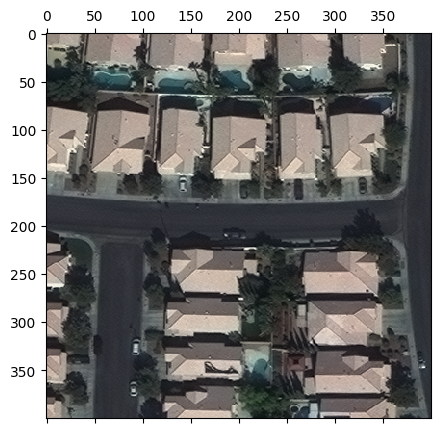

In [5]:
from matplotlib import pyplot as plt

colors_mins = chip.reshape(-1, chip.shape[-1]).min(axis=0)
colors_maxs = chip.reshape(-1, chip.shape[-1]).max(axis=0)
chip_normalized = (chip - colors_mins) / (colors_maxs - colors_mins)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(chip_normalized)
plt.show()

影像降采样，提取指定波段
1. 可以直接像Numpy切片一样进行降采样
2. 降采样到原图像的1/4，提取第2个波段

chip shape: (100, 100, 1)


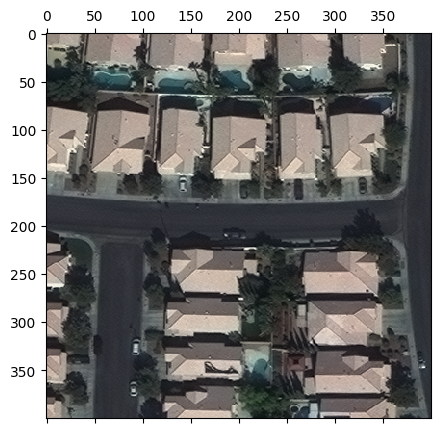

In [6]:
chip = raster_source[:400:4, :400:4, [1]]
print('chip shape:', chip.shape)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(chip_normalized)
plt.show()

在来看看`RasterioSource`的算子操作
1. `get_chip`  
这个严格来说不是算子，是`RasterioSource`提供的一个函数，但是非常有用，就把它拿出来讲下。     
`get_chip`有三个参数：
    1. `Box`，设置裁剪范围
    2. out_shape，设置输出大小，用来采样
    3. bands，选定波段
    
用`get_chip`去裁剪0-400像素，降采样到原来的1/4，提取第2个波段


In [7]:
from rastervision.core.data import Box
chip = raster_source.get_chip(window=Box(xmin=0, ymin=0, xmax=400, ymax=400),
                       out_shape=(100, 100),
                       bands=[1])
chip.shape

(100, 100, 1)

2. `MinMaxTransformer`     
`MinMaxTransformer` 归一化，是直接应用在`RasterSource`上的，是惰性求值，只有当用到数据的时候才会计算
       
重新读取RGB-PanSharpen_AOI_2_Vegas_img205.tif，加上`MinMaxTransformer`

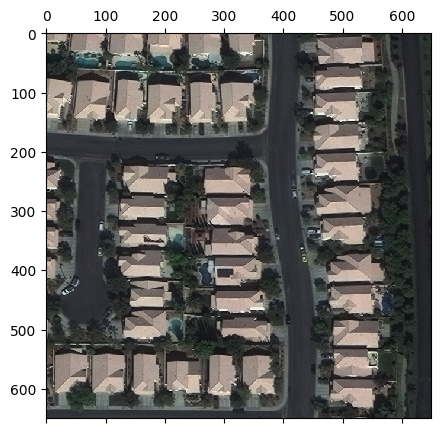

In [8]:
from rastervision.core.data import MinMaxTransformer
file_uri = "data/RGB-PanSharpen_AOI_2_Vegas_img205.tif"
raster_source = RasterioSource(file_uri, allow_streaming=True, raster_transformers=[MinMaxTransformer()])

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(raster_source[:,:,:])
plt.show()

3. `StatsTransformer`    
将非 uint8 类型的像素值转换为 uint8 类型的像素值, 使用通道统计数据（均值和标准差）来进行转换

In [9]:
from rastervision.core.data import StatsTransformer

file_uri = "data/RGB-PanSharpen_AOI_2_Vegas_img205.tif"
stats_transformer = StatsTransformer.from_raster_sources(
    raster_sources=[raster_source],
    max_stds=10)

raster_source_normalized = RasterioSource(
    file_uri,
    allow_streaming=True,
    raster_transformers=[stats_transformer])

stats_transformer.means, stats_transformer.stds

Analyzing chips: 0it [00:00, ?it/s]

(array([84.09806994, 83.72914653, 84.49072767]),
 array([58.44167356, 53.01031765, 49.79958791]))

看一下转换后的效果

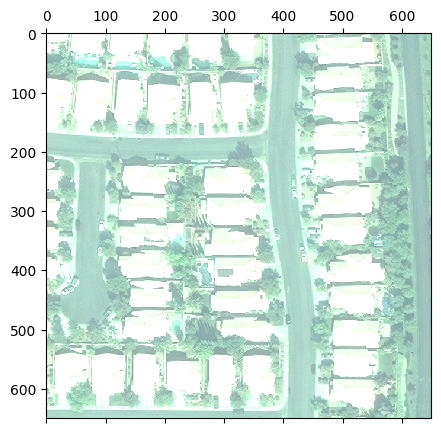

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(raster_source_normalized[:,:,:])
plt.show()

# 练习
1. 现在有一幅影像`data/Hyperspectral/dc.tif`，他有191个波段，如何读取这幅影响，选择第`10, 30, 50, 70, 110, 130`波段，并显示出来

In [12]:
!wget "http://cobweb.ecn.purdue.edu/~biehl/Hyperspectral_Project.zip" -P "data"
!apt install unzip
!unzip "data/Hyperspectral_Project.zip" -d "data/"

--2025-03-05 07:57:09--  http://cobweb.ecn.purdue.edu/~biehl/Hyperspectral_Project.zip
Resolving cobweb.ecn.purdue.edu (cobweb.ecn.purdue.edu)... 128.46.104.20
Connecting to cobweb.ecn.purdue.edu (cobweb.ecn.purdue.edu)|128.46.104.20|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://engineering.purdue.edu/~biehl/Hyperspectral_Project.zip [following]
--2025-03-05 07:57:10--  https://engineering.purdue.edu/~biehl/Hyperspectral_Project.zip
Resolving engineering.purdue.edu (engineering.purdue.edu)... 128.46.104.20
Connecting to engineering.purdue.edu (engineering.purdue.edu)|128.46.104.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109578046 (105M) [application/zip]
Saving to: ‘data/Hyperspectral_Project.zip’

Hyperspectral_Proje 100%[===================>] 104.50M   472KB/s    in 3m 57s  

2025-03-05 08:01:08 (451 KB/s) - ‘data/Hyperspectral_Project.zip’ saved [109578046/109578046]

Reading package lists... Done


In [13]:
from rastervision.core.data import StatsTransformer

file_uri = "data/Hyperspectral_Project/dc.tif"
raster_source = RasterioSource(
    file_uri,
    channel_order=[10, 30, 50, 70, 110, 130],
    raster_transformers=[MinMaxTransformer()])
raster_source.shape, raster_source.dtype

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


((1280, 307, 6), dtype('uint8'))

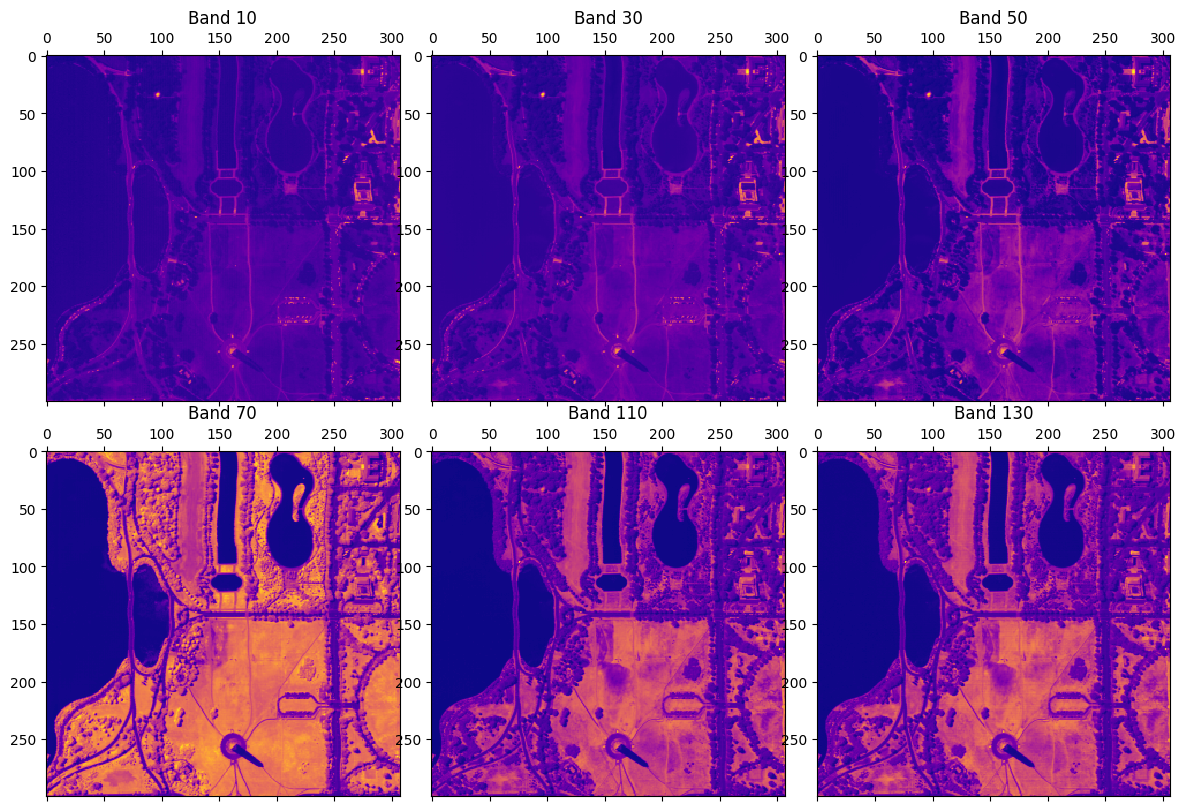

In [15]:
chip = raster_source[200:500, :]
fig, axs = plt.subplots(2, 3, squeeze=True, figsize=(12, 8))
fig.tight_layout(h_pad=1.5, w_pad=-1)
for i, (ax, ch) in enumerate(zip(axs.flat, raster_source.channel_order)):
    ax.matshow(chip[..., i], cmap='plasma')
    ax.set_title(f'Band {ch}')
plt.show()

2. 现在有多幅影像，如何将他们合成一幅影像。
    1. `data/VH.tif`
    2. `data/VV.tif`    
提示：可以使用`MultiRasterSource`

In [25]:
from rastervision.core.data import RasterioSource, MultiRasterSource, MinMaxTransformer

rs_seninel_1_vh = RasterioSource('data/VH.tif', allow_streaming=True, raster_transformers=[MinMaxTransformer()])
rs_seninel_1_vv = RasterioSource('data/VV.tif', allow_streaming=True, raster_transformers=[MinMaxTransformer()])

print('rs_seninel_1_vh', rs_seninel_1_vh.shape, rs_seninel_1_vh.dtype)
print('rs_seninel_1_vv', rs_seninel_1_vv.shape, rs_seninel_1_vv.dtype)

rs_seninel_1_vh (512, 512, 1) uint8
rs_seninel_1_vv (512, 512, 1) uint8


In [26]:
raster_sources = [
    rs_seninel_1_vh,
    rs_seninel_1_vv
]

raster_source_multi = MultiRasterSource(
    raster_sources=raster_sources, primary_source_idx=0)

raster_source_multi.shape, raster_source_multi.dtype

((512, 512, 2), dtype('uint8'))

In [27]:
chip = raster_source_multi[:, :]
chip.shape

(512, 512, 2)

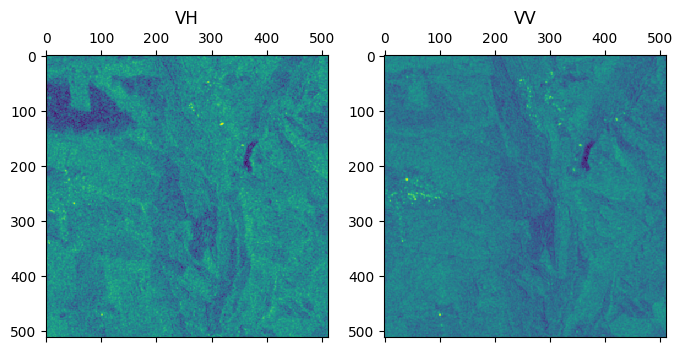

In [33]:
from matplotlib import pyplot as plt

fig, (ax_vh, ax_vv) = plt.subplots(1, 2, figsize=(8, 4))

ax_vh.matshow(chip[..., 0])
ax_vh.set_title('VH')
ax_vv.matshow(chip[..., 1])
ax_vv.set_title('VV')

plt.show()